<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/Random_Forest_S%26W.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**THIS CODE ONLY WORKS FOR DATA WHICH HAS BOTH SUMMER AND WINTER INFO**

Mounting google drive

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Prompted  to provide a path to a zip file, then attempts to unzip it to a /content/dataset directory.  
It first checks if the provided path exists before attempting to unzip.

In [5]:

from google.colab import widgets
import os

zip_path = input("Please paste the path to your zip file from the sidebar: ")
destination = "/content/dataset"

if os.path.exists(zip_path):
    !unzip -q "{zip_path}" -d "{destination}"
    print(f"Successfully unzipped to {destination}")
else:
    print("Error: File path not found. Did you mount your drive?")

Please paste the path to your zip file from the sidebar: /content/drive/MyDrive/lough_garr.zip
Successfully unzipped to /content/dataset


importing Python libraries


In [20]:
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from scipy import ndimage

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



Importing files  

**if no winter files given comment out the winter variables before running**



In [7]:
print("--- Please paste the full paths for the following files ---")

S_RGB_PATH = input("Summer RGB Path: ")
S_NDVI_PATH = input("Summer NDVI Path: ")

W_RGB_PATH = input("Winter RGB Path: ")
W_NDVI_PATH = input("Winter NDVI Path: ")

SHP_PATH = input("Shapefile (.shp) Path: ")

print("\nPaths updated successfully.")

--- Please paste the full paths for the following files ---
Summer RGB Path: /content/dataset/lough_garr/lough_garr_ortho_summer.tif
Summer NDVI Path: /content/dataset/lough_garr/Loughgarr_Summer_NDVI.tif
Winter RGB Path: /content/dataset/lough_garr/Loughgarr_Winter_RGB.tif
Winter NDVI Path: /content/dataset/lough_garr/Loughgarr_Winter_NDVI.tif
Shapefile (.shp) Path: /content/dataset/lough_garr/loughgar_habimap.shp

Paths updated successfully.


**may need to change depedning on columns names**  
Load geospatial data from a shapefile into a GeoPandas DataFrame and define column names for later use

In [8]:
LABEL_COL = 'fid'
NAME_COL = 'HCH_MAPPED'

gdf = gpd.read_file(SHP_PATH)

Getting all the unique fossit codes

In [9]:
print(gdf[NAME_COL].unique())

['PF3' 'WN6']


Reclassification  
taking the unique ecological codes from above cell and simplifying them into broader classes  
**This cell will need to be changed depending on codes**

In [10]:
fossitt_merger = {
    'PF3': 'peatland',
    'WN6': 'Tree & scrub'

}
gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

11 Feature Extraction  

Gathering "spectral signatures" for each habitat type across different seasons (Summer and Winter)  

Instead of analysing the entire map at once, it generates 1,000 random points within each habitat polygon and "drills" through the image layers to extract spectral data (colors and greenness) at those exact spots  

11 distinct features for every point: the raw RGB colors, the NDVI (vegetation health), and the VARI (color-based health index) for both seasons, plus the Delta NDVI—which measures how much the vegetation changes between summer and winter  



In [11]:
all_pixels, all_labels = [], []

# COORDINATED EXTRACTION ---
# Open all 4 sources
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(W_RGB_PATH) as wr, rasterio.open(W_NDVI_PATH) as wn:

    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print("Extracting 11 seasonal features...")
    for idx, row in gdf.iterrows():
        try:
            poly = row.geometry
            min_x, min_y, max_x, max_y = poly.bounds
            points = []
            for _ in range(1000):
                pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
                if Point(pt).within(poly): points.append(pt)
                if len(points) >= 1000: break

            if not points: continue

            # Sample all 4 rasters
            s_rgb_vals = np.array(list(sr.sample(points))).astype('float32')
            s_ndvi_vals = np.array(list(sn.sample(points))).astype('float32')
            w_rgb_vals = np.array(list(wr.sample(points))).astype('float32')
            w_ndvi_vals = np.array(list(wn.sample(points))).astype('float32')

            # Feature Engineering
            # 1-6: Summer RGB + Winter RGB
            # 7-8: Summer NDVI + Winter NDVI
            # 9-10: Summer VARI + Winter VARI (Calculated from RGB)
            s_vari = (s_rgb_vals[:,1]-s_rgb_vals[:,0]) / (s_rgb_vals[:,1]+s_rgb_vals[:,0]-s_rgb_vals[:,2]+1e-5)
            w_vari = (w_rgb_vals[:,1]-w_rgb_vals[:,0]) / (w_rgb_vals[:,1]+w_rgb_vals[:,0]-w_rgb_vals[:,2]+1e-5)
            # 11: Delta NDVI (Seasonality change)
            delta_ndvi = s_ndvi_vals - w_ndvi_vals

            combined = np.column_stack([
                s_rgb_vals, w_rgb_vals,
                s_ndvi_vals, w_ndvi_vals,
                s_vari, w_vari,
                delta_ndvi
            ])

            valid = np.any(s_rgb_vals > 0, axis=1)
            if np.any(valid):
                all_pixels.append(combined[valid])
                all_labels.extend([row['merged_name']] * np.sum(valid))
        except: continue

X, y = np.vstack(all_pixels), np.array(all_labels)

Extracting 11 seasonal features...


Final check on the size of 11 feature dataset

In [12]:
print(f"Total training samples: {len(X)}")

Total training samples: 3056


train:test 70:30  

Random Forest then builds 500 different decision trees that work together to identify the habitats based on the seasonal "fingerprints"  created above  

Using class_weight='balanced' ensures that even rare habitat types aren't ignored in favor of more common ones.  

The resulting Classification Report gives you the definitive accuracy showing exactly how well the model can distinguish between complex classes

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print("\n--- Final Multi-Source Seasonal Report ---")
print(classification_report(y_test, rf.predict(X_test)))


--- Final Multi-Source Seasonal Report ---
              precision    recall  f1-score   support

Tree & scrub       0.85      0.87      0.86       518
    peatland       0.83      0.79      0.81       399

    accuracy                           0.84       917
   macro avg       0.84      0.83      0.84       917
weighted avg       0.84      0.84      0.84       917



Importing dsm files for both seasons

In [15]:
S_DSM = input("Summer DSM Path: ")
W_DSM = input("Winter DSM Path: ")

Summer DSM Path: /content/dataset/lough_garr/lough_garr_dsm_summer.tif
Winter DSM Path: /content/dataset/lough_garr/Loughgarr_Winter_DSM.tif


Checking if CRS allignes for dsm files and shapefile  

Ensuring data layers are perfectly aligned in the same coordinate space  

By reprojecting the shapefile to match the raster's CRS, you guarantee that the points sampled for your model correspond to the exact physical locations on the ground

In [16]:
# Check CRS of all files
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_DSM) as sd:
    print(f"Summer RGB CRS: {sr.crs}")
    print(f"Summer DSM CRS: {sd.crs}")
    gdf = gpd.read_file(SHP_PATH)
    print(f"Shapefile CRS:  {gdf.crs}")

# If they don't match, we must reproject the Shapefile to match the Raster
gdf = gdf.to_crs(sr.crs)

Summer RGB CRS: EPSG:2157
Summer DSM CRS: EPSG:2157
Shapefile CRS:  EPSG:2157


Spatial sampler that picks a specific number of random coordinate points located strictly inside a habitat's boundaries  

It works by creating a "bounding box" around the polygon and randomly generating points within it, keeping only those that fall inside the actual shape

In [17]:
def get_random_points(poly, num_points):
    points = []
    min_x, min_y, max_x, max_y = poly.bounds
    for _ in range(num_points * 3): # 3x attempts to find points within poly
        pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if Point(pt).within(poly):
            points.append(pt)
        if len(points) >= num_points:
            break
    return points

14 features  

Same as 11 features above but adds on also the physical height (DSM) and the seasonal changes—such as how much the vegetation greens up or how its height fluctuates throughout the year  

The code automatically filters out "no-data" areas and synchronizes everything into a clean dataset  

Gives final dataset size


In [18]:
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, rasterio.open(S_DSM) as sd, \
     rasterio.open(W_RGB_PATH) as wr, rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print("Extracting 14 Seasonal + Height features...")
    for idx, row in gdf.iterrows():
        pts = get_random_points(row.geometry, 1000)
        if not pts: continue

        # Sample all 6 rasters at point locations
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        w_rgb = np.array(list(wr.sample(pts))).astype('float32')
        w_nd  = np.array(list(wn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()
        w_h   = np.array(list(wd.sample(pts))).astype('float32').flatten()

        # Feature Engineering
        s_vari = (s_rgb[:,1]-s_rgb[:,0]) / (s_rgb[:,1]+s_rgb[:,0]-s_rgb[:,2]+1e-5)
        w_vari = (w_rgb[:,1]-w_rgb[:,0]) / (w_rgb[:,1]+w_rgb[:,0]-w_rgb[:,2]+1e-5)

        # Combine into 14-column stack
        combined = np.column_stack([
            s_rgb, w_rgb,          # 1-6
            s_nd, w_nd,            # 7-8
            s_vari, w_vari,        # 9-10
            (s_nd - w_nd),         # 11: Delta NDVI
            s_h, w_h,              # 12-13
            (s_h - w_h)            # 14: Delta Height
        ])

        # Filter: Ensure Summer RGB is not black
        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]
        num_valid = valid_pixels.shape[0]

        if num_valid > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * num_valid)

X = np.vstack(all_pixels)
y = np.array(all_labels)
print(f"Final Data Sync: X={X.shape}, y={y.shape}")

Extracting 14 Seasonal + Height features...
Final Data Sync: X=(6287, 15), y=(6287,)


train:test 70:30  

Random Forest then builds 500 different decision trees that work together to identify the habitats based on the seasonal "fingerprints"  created above  

Using class_weight='balanced' ensures that even rare habitat types aren't ignored in favor of more common ones.  

The resulting Classification Report gives you the definitive accuracy showing exactly how well the model can distinguish between complex classes

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("\n--- FINAL 14-FEATURE REPORT ---")
print(classification_report(y_test, y_pred))


--- FINAL 14-FEATURE REPORT ---
              precision    recall  f1-score   support

Tree & scrub       0.91      0.95      0.93      1148
    peatland       0.91      0.86      0.88       739

    accuracy                           0.91      1887
   macro avg       0.91      0.90      0.91      1887
weighted avg       0.91      0.91      0.91      1887



plotting confusion matrix

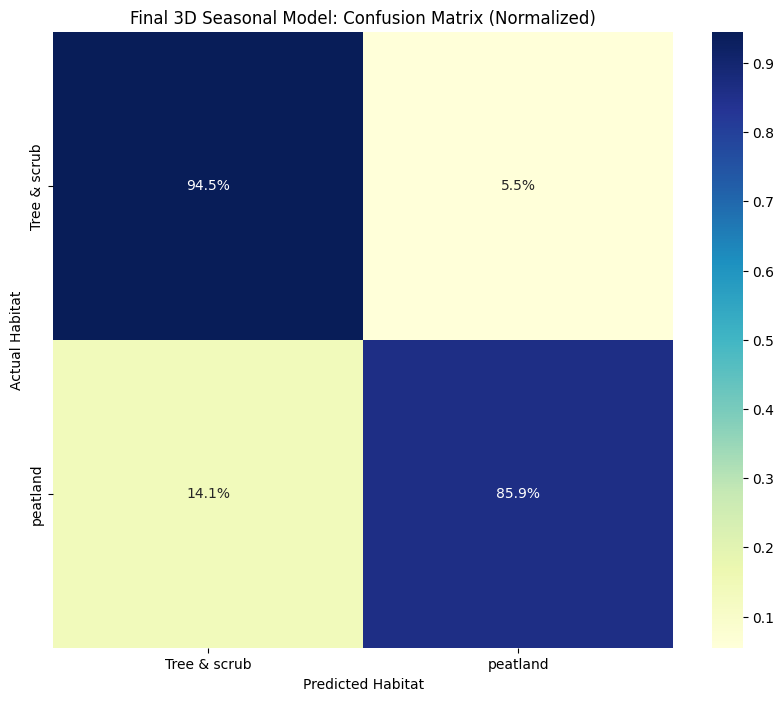

In [21]:

# 1. Get the unique classes from your cleaned y_test to ensure labels match
# This prevents errors if some rare classes were merged out
labels = np.unique(y_test)

# 2. Generate the predictions
y_pred = rf.predict(X_test)

# 3. Create the matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 4. Convert to percentages (Normalized)
# We add a tiny epsilon (1e-9) to avoid division by zero if a class is empty
cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

# 5. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title('Final 3D Seasonal Model: Confusion Matrix (Normalized)')
plt.xlabel('Predicted Habitat')
plt.ylabel('Actual Habitat')
plt.show()

Horn’s Method, a standard algorithm used in GIS software (like ArcGIS or QGIS) to calculate the steepness of a landscape from a Digital Elevation Model (DEM)  

It looks at a $3 \times 3$ grid of elevation pixels to determine how quickly the height changes in both the horizontal ($x$) and vertical ($y$) directions.

In [22]:
#slope
def calculate_local_slope(window, res=1.0):
    """Calculates slope in degrees from a 3x3 elevation window."""
    # Horn's method for slope
    dz_dx = ((window[0,2] + 2*window[1,2] + window[2,2]) -
             (window[0,0] + 2*window[1,0] + window[2,0])) / (8 * res)
    dz_dy = ((window[2,0] + 2*window[2,1] + window[2,2]) -
             (window[0,0] + 2*window[0,1] + window[0,2])) / (8 * res)

    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    return np.degrees(slope_rad)

16 features

Includes a moving-window analysis on the elevation data, it captures the local slope, which is a vital indicator for habitats defined by their hydrology and position on the landscape.  

Gives dataset size


In [23]:
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, rasterio.open(S_DSM) as sd, \
     rasterio.open(W_RGB_PATH) as wr, rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    RES = sd.res[0] # Get resolution for slope calc (likely 1.0 or 0.5)
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print("Extracting 16 Features (Seasonal + Height + Slope)...")
    for idx, row in gdf.iterrows():
        pts = get_random_points(row.geometry, 1000)
        if not pts: continue

        # Standard sampling
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        w_rgb = np.array(list(wr.sample(pts))).astype('float32')
        w_nd  = np.array(list(wn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()
        w_h   = np.array(list(wd.sample(pts))).astype('float32').flatten()

        # Slope Sampling (requires reading a small window around each point)
        s_slopes, w_slopes = [], []
        for pt in pts:
            # Get pixel coordinates for the DSMs
            row_idx, col_idx = sd.index(pt[0], pt[1])
            # Read 3x3 window
            win = rasterio.windows.Window(col_idx - 1, row_idx - 1, 3, 3)

            s_win = sd.read(1, window=win, boundless=True, fill_value=0)
            w_win = wd.read(1, window=win, boundless=True, fill_value=0)

            s_slopes.append(calculate_local_slope(s_win, RES))
            w_slopes.append(calculate_local_slope(w_win, RES))

        # Feature Engineering
        s_vari = (s_rgb[:,1]-s_rgb[:,0]) / (s_rgb[:,1]+s_rgb[:,0]-s_rgb[:,2]+1e-5)
        w_vari = (w_rgb[:,1]-w_rgb[:,0]) / (w_rgb[:,1]+w_rgb[:,0]-w_rgb[:,2]+1e-5)

        # 16-column stack
        combined = np.column_stack([
            s_rgb, w_rgb,          # 1-6
            s_nd, w_nd,            # 7-8
            s_vari, w_vari,        # 9-10
            (s_nd - w_nd),         # 11: Delta NDVI
            s_h, w_h,              # 12-13
            (s_h - w_h),           # 14: Delta Height
            s_slopes, w_slopes     # 15-16: Slope layers
        ])

        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]
        if valid_pixels.shape[0] > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * valid_pixels.shape[0])

X = np.vstack(all_pixels)
y = np.array(all_labels)
print(f"Extraction Complete: X={X.shape}")

Extracting 16 Features (Seasonal + Height + Slope)...
Extraction Complete: X=(6268, 17)


train:test 70:30  

Random Forest then builds 500 different decision trees that work together to identify the habitats based on the seasonal "fingerprints"  created above  

Using class_weight='balanced' ensures that even rare habitat types aren't ignored in favor of more common ones.  

The resulting Classification Report gives you the definitive accuracy showing exactly how well the model can distinguish between complex classes

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("\n--- FINAL 16-FEATURE REPORT ---")
print(classification_report(y_test, y_pred))


--- FINAL 16-FEATURE REPORT ---
              precision    recall  f1-score   support

Tree & scrub       0.92      0.95      0.93      1143
    peatland       0.92      0.87      0.89       738

    accuracy                           0.92      1881
   macro avg       0.92      0.91      0.91      1881
weighted avg       0.92      0.92      0.92      1881



CONFUSION MATRIX


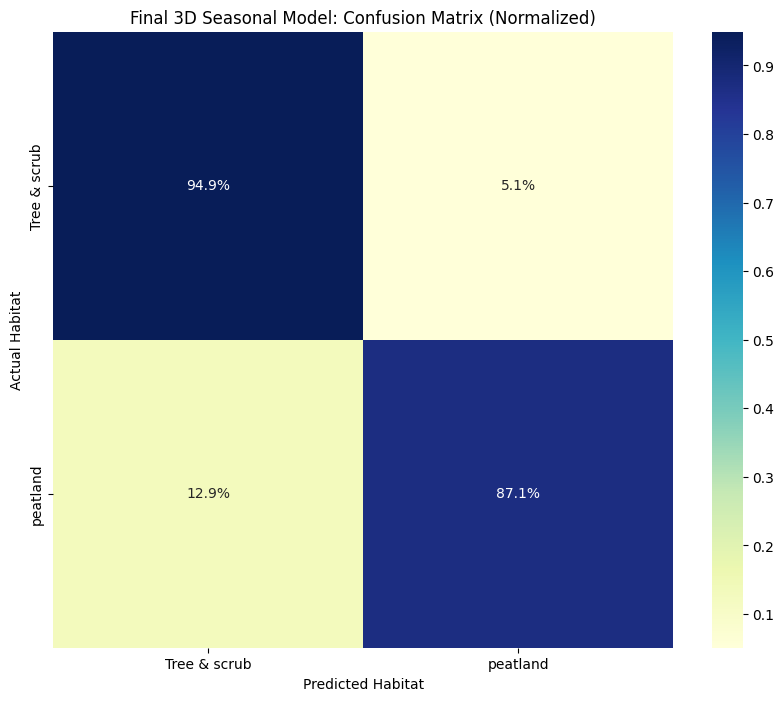

In [25]:
# 1. Get the unique classes from your cleaned y_test to ensure labels match
# This prevents errors if some rare classes were merged out
labels = np.unique(y_test)

# 2. Generate the predictions
y_pred = rf.predict(X_test)

# 3. Create the matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 4. Convert to percentages (Normalized)
# We add a tiny epsilon (1e-9) to avoid division by zero if a class is empty
cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

# 5. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title('Final 3D Seasonal Model: Confusion Matrix (Normalized)')
plt.xlabel('Predicted Habitat')
plt.ylabel('Actual Habitat')
plt.show()

32 features  

Reverse-engineering the Near-Infrared band and calculating spectral indices  

This multi-layered approach—combining seasonal color shifts, terrain slope, and structural height—provides the Random Forest with a massive "search space" to accurately distinguish between the complex ecological classes

In [ ]:
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, rasterio.open(S_DSM) as sd, \
     rasterio.open(W_RGB_PATH) as wr, rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    RES = sd.res[0]
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print("Extracting 32 Features (Seasonal + Height + Slope + Advanced Indices)...")
    for idx, row in gdf.iterrows():
        pts = get_random_points(row.geometry, 1000)
        if not pts: continue

        # 1. Base Sampling
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        w_rgb = np.array(list(wr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        w_nd  = np.array(list(wn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()
        w_h   = np.array(list(wd.sample(pts))).astype('float32').flatten()

        # 2. Slope Sampling
        s_slopes, w_slopes = [], []
        for pt in pts:
            r_idx, c_idx = sd.index(pt[0], pt[1])
            win = rasterio.windows.Window(c_idx - 1, r_idx - 1, 3, 3)
            s_win = sd.read(1, window=win, boundless=True, fill_value=0)
            w_win = wd.read(1, window=win, boundless=True, fill_value=0)
            s_slopes.append(calculate_local_slope(s_win, RES))
            w_slopes.append(calculate_local_slope(w_win, RES))

        # 3. Safe NIR Back-calculation
        # Clamp NDVI to [-0.99, 0.99] to prevent (1 - nd) becoming zero or negative
        s_nd_safe = np.clip(s_nd, -0.99, 0.99)
        w_nd_safe = np.clip(w_nd, -0.99, 0.99)

        s_nir = s_rgb[:, 0] * (1 + s_nd_safe) / (1 - s_nd_safe + 1e-5)
        w_nir = w_rgb[:, 0] * (1 + w_nd_safe) / (1 - w_nd_safe + 1e-5)

        # 4. Advanced Indices Calculation (Internal helper for safety)
        def calc_indices(r, g, b, nir):
            eps = 1e-5
            rvi = nir / (r + eps)
            savi = ((nir - r) / (nir + r + 0.5 + eps)) * 1.5
            evi = 2.5 * ((nir - r) / (nir + 6 * r - 7.5 * b + 1 + eps))
            gndvi = (nir - g) / (nir + g + eps)
            grvi = (g - r) / (g + r + eps)
            nrvi = (rvi - 1) / (rvi + 1 + eps)
            ndwi = (g - nir) / (g + nir + eps)
            vari = (g - r) / (g + r - b + eps)
            return np.column_stack([rvi, savi, evi, gndvi, grvi, nrvi, ndwi, vari])

        s_idx_stack = calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir)
        w_idx_stack = calc_indices(w_rgb[:,0], w_rgb[:,1], w_rgb[:,2], w_nir)

        # 5. Final Assembly (32 Features Total)
        combined = np.column_stack([
            s_rgb, w_rgb,          # 1-6
            s_nd, w_nd,            # 7-8
            s_h, w_h,              # 9-10
            s_nir, w_nir,          # 11-12
            s_idx_stack,           # 13-20 (8 summer indices)
            w_idx_stack,           # 21-28 (8 winter indices)
            s_slopes, w_slopes,    # 29-30
            (s_nd - w_nd),         # 31: Delta NDVI
            (s_h - w_h)            # 32: Delta Height
        ])

        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]
        if valid_pixels.shape[0] > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * valid_pixels.shape[0])

# Stack and Clean for Random Forest
X = np.vstack(all_pixels)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
y = np.array(all_labels)

print(f"Extraction Complete: X shape is {X.shape}")

Extracting 32 Features (Seasonal + Height + Slope + Advanced Indices)...


train:test 70:30  

Random Forest then builds 500 different decision trees that work together to identify the habitats based on the seasonal "fingerprints"  created above  

Using class_weight='balanced' ensures that even rare habitat types aren't ignored in favor of more common ones.  

The resulting Classification Report gives you the definitive accuracy showing exactly how well the model can distinguish between complex classes

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("\n--- FINAL 32-FEATURE REPORT ---")
print(classification_report(y_test, y_pred))


--- FINAL 32-FEATURE REPORT ---
              precision    recall  f1-score   support

Tree & scrub       0.92      0.94      0.93      1141
    peatland       0.91      0.88      0.89       734

    accuracy                           0.92      1875
   macro avg       0.92      0.91      0.91      1875
weighted avg       0.92      0.92      0.92      1875



confusion matrix

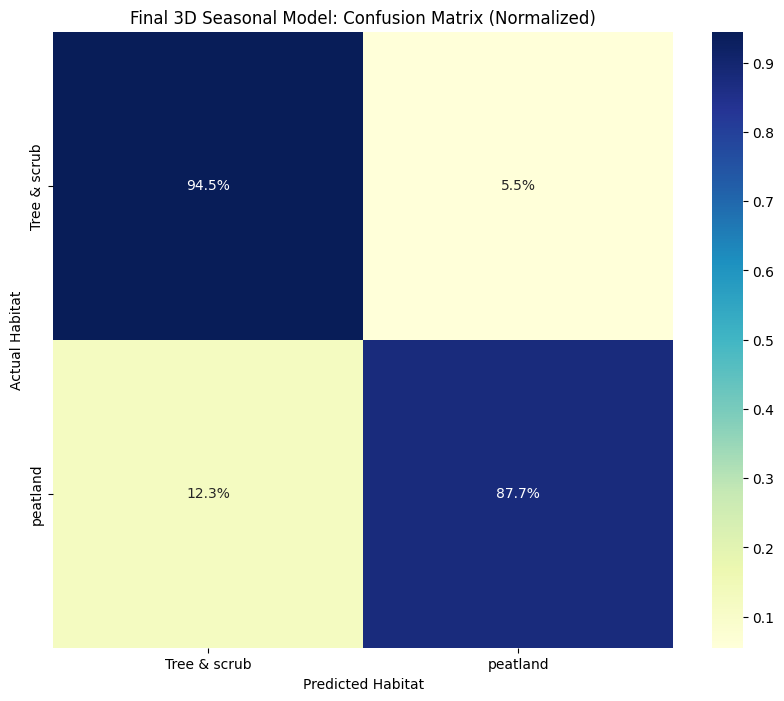

In [28]:
# 1. Get the unique classes from your cleaned y_test to ensure labels match
# This prevents errors if some rare classes were merged out
labels = np.unique(y_test)

# 2. Generate the predictions
y_pred = rf.predict(X_test)

# 3. Create the matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 4. Convert to percentages (Normalized)
# We add a tiny epsilon (1e-9) to avoid division by zero if a class is empty
cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

# 5. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title('Final 3D Seasonal Model: Confusion Matrix (Normalized)')
plt.xlabel('Predicted Habitat')
plt.ylabel('Actual Habitat')
plt.show()